# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, March 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius <christopher.lucasius@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1Q9t0MOpi6xapk_MvcCoNUSSg3Jhz-_Qp/view?usp=sharing

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/APS360_Labs/LAB_4/Lab_4_Data_Imputation.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/APS360_Labs/LAB_4/Lab_4_Data_Imputation.ipynb to html
[NbConvertApp] Writing 780133 bytes to /content/drive/MyDrive/APS360_Labs/LAB_4/Lab_4_Data_Imputation.html


In [39]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [5]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [6]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [7]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [8]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [9]:
#Get summary statistics
subdf.describe()

,age,yredu,capgain,caploss,workhr
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [11]:
# Declaring names of coulums that need to be normalized
names = ["age", "yredu", "capgain", "caploss", "workhr"]

# Normalization
for i in range(len(names)):
  col_name = names[i]
  col = df[col_name]
  normalized_col = (col-col.min())/(col.max()-col.min())
  df[col_name] = normalized_col

df.describe()

,age,fnlwgt,yredu,capgain,caploss,workhr
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.295639,1.897784e+05,0.605379,0.010777,0.020042,0.402423
std,0.186855,1.055500e+05,0.171515,0.073854,0.092507,0.125994
min,0.000000,1.228500e+04,0.000000,0.000000,0.000000,0.000000
25%,0.150685,1.178270e+05,0.533333,0.000000,0.000000,0.397959
50%,0.273973,1.783560e+05,0.600000,0.000000,0.000000,0.397959
75%,0.424658,2.370510e+05,0.733333,0.000000,0.000000,0.448980
max,1.000000,1.484705e+06,1.000000,1.000000,1.000000,1.000000


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [26]:
num_males = sum(df["sex"] == " Male")
num_females = sum(df["sex"] == " Female")
total = len(df)

perc_male = num_males/total *100
perc_male = round(perc_male, 1)

perc_female = num_females/total *100
perc_female = round(perc_female, 1)

print('The percentage of males in the dataset is : ', perc_male, '%')
print('The percentage of females in the dataset is : ', perc_female, '%')

The percentage of males in the dataset is :  66.9 %
The percentage of females in the dataset is :  33.1 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [15]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [18]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

perc = (df_with_missing.shape[0]/len(df))*100
perc = round(perc, 1)

print('Records with missing features:', df_with_missing.shape[0])
print('Records without missing features:', df_not_missing.shape[0])
print('Percentage of missing:', perc,'%')

Records with missing features: 1843
Records without missing features: 30718
Percentage of missing: 5.7 %


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [19]:
df_not_missing['work'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
Name: work, dtype: int64

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [20]:
data = pd.get_dummies(df_not_missing)

In [21]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [24]:
dim = data.shape
print('The number of columns in the dataframe data is: ', dim[1])

The number of columns in the dataframe data is:  57


The number of columns comes from taking all the possible categorical values and turning them into new columns. Each row with was originally containing categorical text for the corresponding column is set to 1 while all other possible values in that row remain 0). This step allow us to turn the data entirely numerical, making it easier to navigate.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [27]:
datanp = data.values.astype(np.float32)

In [29]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    max_position = np.unravel_index(np.argmax(onehot), onehot.shape)[0]
    category = cat_values[feature]
    output = category[max_position]

    return output

In [31]:
#Expected output State-gov
print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))
#Expected output Private
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))

State-gov
Private


In [32]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [37]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)
np.random.shuffle(datanp)

row, col = datanp.shape
train_row = round(0.7*row)
val_row = round(0.15*row) 

train_data = datanp[0:train_row]
val_data = datanp[train_row:train_row+val_row]
test_data = datanp[-val_row:]

print('Number of rows in the training dataset: ', train_data.shape[0])
print('Number of rows in the validation dataset: ', val_data.shape[0])
print('Number of rows in the testing dataset: ', test_data.shape[0])

Number of rows in the training dataset:  21503
Number of rows in the validation dataset:  4608
Number of rows in the testing dataset:  4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [47]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 25), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(25, 11),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 25), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(25, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

Data in the columns of the categorical one-hot encoded values are normalized so returned values must be in rage (0,1)

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [57]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, 
                                                   learning_rate, epoch)
    return path

def train(model, train_loader, valid_loader, batch_size, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    #initialize empty vectors
    train_loss = np.zeros(num_epochs) 
    train_acc = np.zeros(num_epochs) 
    val_loss = np.zeros(num_epochs) 
    val_acc = np.zeros(num_epochs) 

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        for iterations, data in enumerate(train_loader,0):
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
        train_loss[epoch] = float(total_train_loss/(iterations+1))
        val_loss[epoch] = get_loss(model, val_loader, criterion) 
        # Get accuracy values
        train_acc[epoch] = get_accuracy(model, train_loader) #generate the training accuracy for this epoch
        val_acc[epoch] = get_accuracy(model, val_loader) #generate the validation accuracy for this epoch
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # Plotting Graphs
    plt.title("Training Loss")
    plt.plot(np.arange(num_epochs), train_loss, label="Train")
    plt.plot(np.arange(num_epochs), val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Accuracy")
    plt.plot(np.arange(num_epochs), train_acc, label="Train")
    plt.plot(np.arange(num_epochs), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [44]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

def get_loss(model, loader, criterion):
    """ Evaluate the network loss on the validation set.
     """
    total_loss = 0.0
    i = 0
    for col in catcols: 
      for data in (loader):
        datam = zero_out_random_feature(data.clone())
        reconstruction = model(datam) 
        loss = criterion(reconstruction, data) 
        total_loss += loss.item()
        i+=1 
    loss = float(total_loss)/(i + 1)
    return loss

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

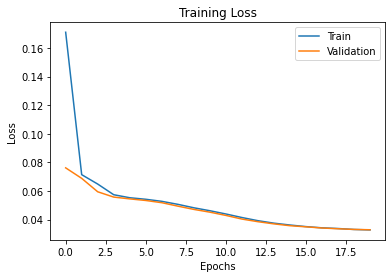

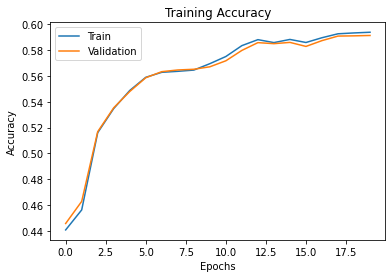

In [58]:
encoder = AutoEncoder()

#initial hyperparameters
batch_size = 32
num_epochs = 20
learning_rate = 0.0001

train_loader= torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle= True)
val_loader= torch.utils.data.DataLoader(val_data, batch_size= batch_size, shuffle= True)

train(encoder, train_loader, val_loader, batch_size, num_epochs, learning_rate)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [59]:
# Hyperparameters chosen for tuning
"""
I have selected a "high" value and a "low" value for each variable
First two testings keep number of epoches equal to 25 and combine: 
1. smaller learning rate with larger batch size 
2. larger learning rate with smaller batch size
Second two testings keep number of epoches equal to 50 and combine: 
3. smaller learning rate with larger batch size 
4. larger learning rate with smaller batch size
"""
batch_size_1 = 32
batch_size_2 = 64
num_epochs_1 = 25
num_epochs_2 = 50
learning_rate_1 = 0.001
learning_rate_2 = 0.0003

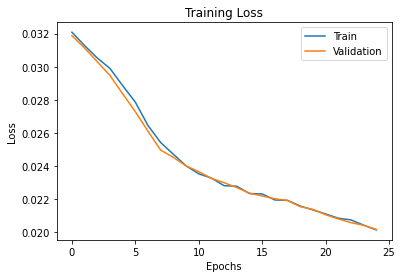

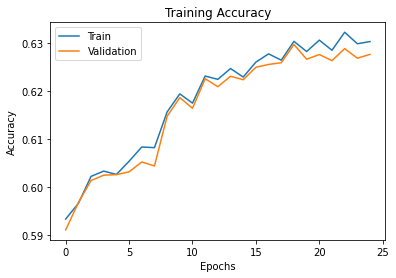

In [60]:
train(encoder, train_loader, val_loader, batch_size_1, num_epochs_1, learning_rate_2)

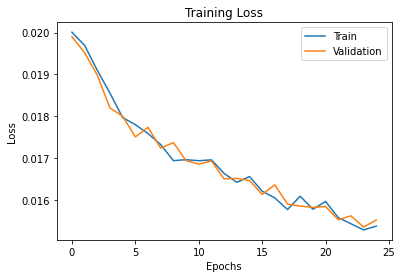

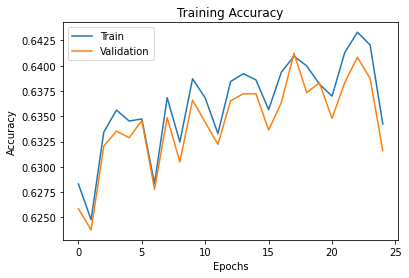

In [61]:
train(encoder, train_loader, val_loader, batch_size_2, num_epochs_1, learning_rate_1)

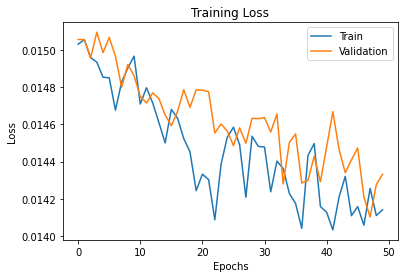

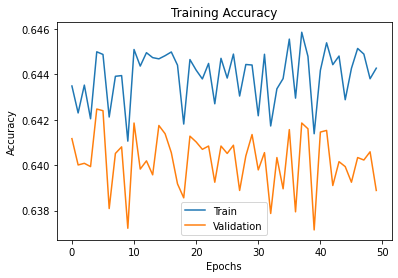

In [62]:
train(encoder, train_loader, val_loader, batch_size_1, num_epochs_2, learning_rate_2)

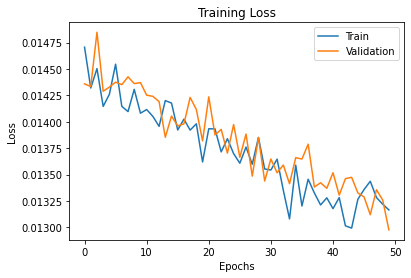

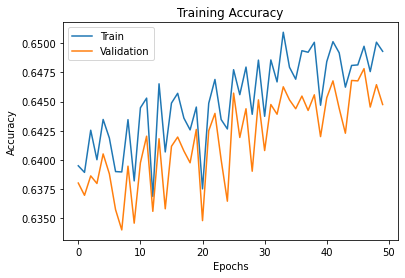

In [64]:
train(encoder, train_loader, val_loader, batch_size_2, num_epochs_2, learning_rate_1)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

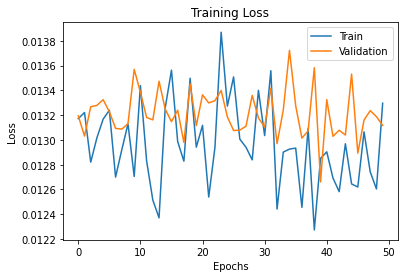

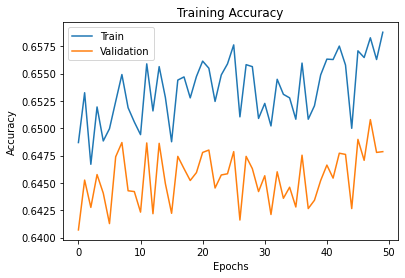

In [66]:
test_loader= torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle= True)
train(encoder, test_loader, val_loader, batch_size_2, num_epochs_2, learning_rate_1)

In [73]:
model_path = get_model_name("AutoEncoder", batch_size_2, learning_rate_1, num_epochs_2-1)
state = torch.load(model_path)
encoder = AutoEncoder()
encoder.load_state_dict(state)

test_loader= torch.utils.data.DataLoader(test_data, batch_size_2, shuffle= True)

test_acc= get_accuracy(encoder, test_loader)
accuracy = np.round(test_acc * 100, 2)
print('The test accuracy is', accuracy,'%')

The test accuracy is 65.88 %


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [75]:
col_max = []
for i in range(len(catcols)):
  x = str(catcols[i])
  y = len(cat_values[x])
  col_sum = []
  for j in range(y):
    reform_col = str(x)+'_ '+str(cat_values[x][j])
    catsum = data[str(reform_col)].sum()
    col_sum.append(catsum)
  col_max.append(max(col_sum)) #max value for each categorization
# Average accuracy
average_col_count = int(sum(col_max)/len(col_max))
baseline_accuracy = round(float(average_col_count/len(data)),4)*100
print('The baseline accuracy is', baseline_accuracy,'%')

The baseline accuracy is 45.92 %


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The baseline model accuracy is lower than the accuracy I got for my trained model:

45.92 % < 65.88 %

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [78]:
pd.DataFrame(data = [test_data[0]], columns = data.columns)

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.054795,0.6,0.0,0.0,0.295918,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


I personally think that for a human it would not be reasonable to make such a guess. Correlations between age, gender, marriage, work etc. is so complicated that would be very hard to generalize in order to make assumptions. 

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [84]:
loader= torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
for i in loader:  
  inp = i.detach().numpy()
  out = encoder(zero_out_feature(i.clone(), "edu")).detach().numpy()
  print('Model prediction for this person education:', get_feature(out[0], "edu"))
  break

Model prediction for this person education: HS-grad


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [85]:
education = []
span = len(cat_values['edu'])
for j in range(span):
  reform_col = 'edu'+'_ '+str(cat_values['edu'][j])
  education.append(reform_col)
pd.DataFrame(data[education].sum(),).sort_values(by=0,ascending=False)

,0
edu_ HS-grad,9968
edu_ Some-college,6775
edu_ Bachelors,5182
edu_ Masters,1675
edu_ Assoc-voc,1321
edu_ 11th,1056
edu_ Assoc-acdm,1020
edu_ 10th,831
edu_ 7th-8th,573
edu_ Prof-school,558


Baseline model's prediction is HS-grad